Z wykorzystaniem modelu CreditMetrics wyznaczyć 99,9% VaR i ES dla portfela składającego się z portfela trzech poniżej opisanych obligacji skarbowych:

    3-letnia obligacja o ratingu A (cena wykupu 100 000 zł, subordinated),
    5-letnia obligacja o ratingu B (cena wykupu 50 000 zł, roczne kupony 5000 zł, senior secured),
    2-letnia obligacja o ratingu CCC (cena wykupu 50 000 zł, roczne kupony 10 000 zł, senior unsecured).

W badaniu założyć, że współczynniki korelacji między inwestycjami w portfelu wynoszą: r12 = 0.2, r13 = 0.15, r23 = 0.4.

Zbadać, w jaki sposób zmieniłyby się wyniki, jeśli założylibyśmy, że inwestycje w portfelu nie są skorelowane. Jak uzyskane wyniki łączą się z pojęciem "dywersyfikacji ryzyka".
Na podstawie dokumentacji technicznej CreditMetrics na przykładzie opisać, jakie są sposoby wyznaczania korelacji w modelu.

In [235]:
import numpy as np
import pandas as pd

In [236]:
#macierz przejścia dla ratingów
mp = np.array([
    [93.40, 5.94, 0.64, 0.00, 0.02, 0.00, 0.00, 0.00],
    [1.61, 90.55, 7.46, 0.26, 0.09, 0.01, 0.00, 0.02],
    [0.07, 2.28, 92.44, 4.63, 0.45, 0.12, 0.01, 0.00],
    [0.05, 0.26, 5.51, 88.48, 4.76, 0.71, 0.08, 0.15],
    [0.02, 0.05, 0.42, 5.16, 86.91, 5.91, 0.24, 1.29],
    [0.00, 0.04, 0.13, 0.54, 6.35, 84.22, 1.91, 6.81],
    [0.00, 0.00, 0.00, 0.62, 2.05, 4.08, 69.20, 24.05],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 100.00]
])
mp = mp/100
mp = pd.DataFrame(mp, columns = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'Def'],
                  index = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'Def'])

In [237]:
from scipy.stats import zscore
#stworzenie kumulatywnej macierzy przejścia
mp_cumulative = mp.cumsum(axis=1)
mp_cumulative = mp_cumulative.div(mp_cumulative.iloc[:, -1], axis=0)

In [238]:
import scipy.stats as st
mp_z = mp_cumulative.copy()
mp_z = 1 - mp_z
mp_z = -st.norm.ppf(mp_z)
mp_z = pd.DataFrame(mp_z, columns=mp.columns, index=mp.index)

In [239]:
#macierz stóp zwrotu ogółem
msz = pd.DataFrame([[3.60, 4.17, 4.73, 5.12],
                    [3.65, 4.22, 4.78, 5.17],
                    [3.72, 4.32, 4.93, 5.32],
                    [4.10, 4.67, 5.25, 5.63],
                    [5.55, 6.02, 6.78, 7.27],
                    [6.05, 7.02, 8.03, 8.52],
                    [15.05, 15.02, 14.03, 13.52]],
                    columns = ['1Y', '2Y', '3Y', '4Y'],
                    index = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC'])
msz = msz/100

In [240]:
#stopa odzysku według klasy obligacji
data = {'Mean': [53.80, 51.13, 38.52, 32.74, 17.09],
        'SD': [26.86, 25.45, 23.81, 20.18, 10.90]}
mso = pd.DataFrame(data,index = ["Senior Secured", "Senior Unsecured",
                                 "Senior Subordinated", "Subordinated", "Junior Subordinated"])
mso = mso/100

In [241]:
mcorr = pd.DataFrame([[1.0, 0.2, 0.15],
                      [0.2, 1.0, 0.4],
                      [0.15, 0.4, 1.0]],
                      columns=['r1', 'r2', 'r3'],
                      index=['r1', 'r2', 'r3'])

In [242]:
valA = 100000 #subordinated
valB = 50000 #senior secured
couponB = 5000
valCCC = 50000 #senior unsecured
couponCCC = 10000

In [243]:
#wycena obligacji bez zmiany ratingu
#bez kupony
def bond_valuation_nc(value, msz, maturity, rating):
    return value/(1+msz.loc[rating, '{}Y'.format(maturity-1)])
#z kuponami
def bond_valuation_c(value, msz, maturity, coupon, rating):
    return np.sum([coupon / (1 + msz.loc[rating,'{}Y'.format(maturity-1)]) ** i for i in range(2, maturity + 1)]) + (value / (1 + msz.loc[rating,'{}Y'.format(maturity-1)]) ** maturity)

In [244]:
#wycena portfela bez zmiany ratingu
portfolio_value = bond_valuation_nc(valA, msz, 3, 'A') + bond_valuation_c(valB, msz, 5, couponB, 'B') + bond_valuation_c(valCCC, msz, 2, couponCCC, 'CCC')

In [245]:
import numpy as np
# Symulacja scenariuszy
#np.random.seed(123)
num_scenarios = 10000
scenarios = np.random.multivariate_normal(mean=np.zeros(len(mcorr)), cov=mcorr, size=num_scenarios)
scenarios = pd.DataFrame(scenarios, columns=["Obligacja1","Obligacja2","Obligacja3"])

value_rangeA = [-float('inf'),-3.19, -1.99, 1.63, 2.52, 3.01, 3.72, 3.73, float('inf')]
value_rangeB = [-float('inf'),-3.5, -3.35, -2.93, -2.45, -1.47, 1.36, 1.49, float('inf')]
value_rangeCCC = [-float('inf'),-4, -3.5, -3, -2.50, -1.93, -1.49, 0.70, float('inf')]
letters = ['Def', 'CCC', 'B', 'BB', 'BBB', 'A', 'AA', 'AAA']
letters = letters[::-1]

scenarios['OblA'] = pd.cut(scenarios['Obligacja1'], bins=value_rangeA, labels=letters)
scenarios['OblB'] = pd.cut(scenarios['Obligacja2'], bins=value_rangeB, labels=letters)
scenarios['OblCCC'] = pd.cut(scenarios['Obligacja3'], bins=value_rangeCCC, labels=letters)
scenarios = scenarios[['OblA', 'OblB', 'OblCCC']]

In [246]:
def value_when_bankrupt(value, seniority):
    val = value * np.random.normal(mso.loc[seniority, 'Mean'], (mso.loc[seniority, 'SD']))
    if(val<0):
        return -val
    else:
        return val

In [247]:
scenarios['Valuation_A'] = scenarios.apply(lambda column: value_when_bankrupt(valA, 'Subordinated') if column['OblA'] == 'Def' else bond_valuation_nc(valA, msz, 3, column['OblA']), axis=1)
scenarios['Valuation_B'] = scenarios.apply(lambda column: value_when_bankrupt(valB, 'Senior Secured') if column['OblB'] == 'Def' else bond_valuation_c(valB, msz, 5, couponB, column['OblB']), axis=1)
scenarios['Valuation_CCC'] = scenarios.apply(lambda column: value_when_bankrupt(valCCC, 'Senior Unsecured') if column['OblCCC'] == 'Def' else bond_valuation_c(valCCC, msz, 2, couponCCC, column['OblCCC']), axis=1)
scenarios["Portfolio Value"] = scenarios['Valuation_A'] + scenarios['Valuation_B'] + scenarios['Valuation_CCC']
scenarios["Portfolio Diff"] =  portfolio_value - scenarios["Portfolio Value"]
differences = scenarios["Portfolio Diff"]

In [248]:
var = differences.quantile(0.999)
print(var)

cvar = differences[differences >= var].quantile(0.999)
print(cvar)


75715.44934315071
84699.09124253807


c:\Users\lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


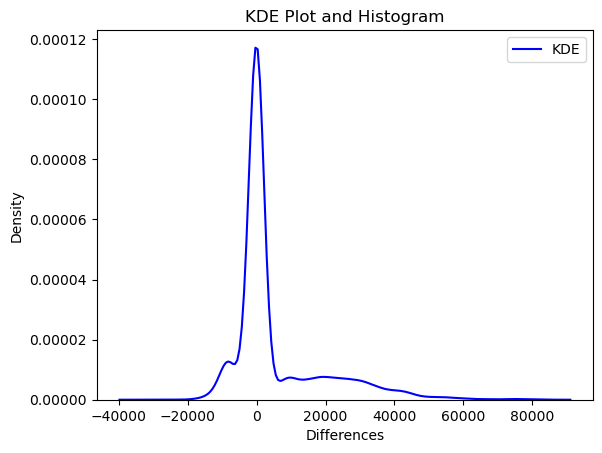

In [258]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot KDE plot
sns.kdeplot(differences, color='blue', label='KDE')

# Plot histogram
#sns.histplot(differences, label='Histogram')

# Set labels and title
plt.xlabel('Differences')
plt.ylabel('Density')
plt.title('KDE Plot and Histogram')

# Show legend
plt.legend()

# Show the plot
plt.show()



sprawdzamy obligacje za rok, czyli mając obligacje 2,5 i 3 letnie będziemy mieli obligacje 1,4 i 2 letnie
wycena polega na tym, że dyskontujemy wszystkie przepływy finansowe na dany moment w czasie
jeśli jest bankrut to losujemy z rozkładu N(m,s) stopy odzysku